In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xml.etree.ElementTree
import os,glob,sys
import pandas as pd
from sklearn.decomposition import PCA
import pylab as plt
import seaborn as sns
import numpy as np

sys.path.append("../../../pymzm/")
from mzmine import pick_peaks, align, match_aligned_to_original, load_aligned_peaks

In [3]:
WIN = 'D:/'
MAC = '/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/'

osp = MAC

In [4]:
MNET_PATH = '/Users/anamaria/git/molnet/code/'
sys.path.append(MNET_PATH)

### Load text files with aligned data


In [5]:
with_mod = pd.read_csv(osp+'positive_mode/samples/limma_independent_toptable_features.csv', sep = '\t')
feat_des = pd.read_csv(osp+'pymz/mzmine/peak_picked_files/feature_description.csv', sep = ',')

without_mod = pd.read_csv(osp+'pymz/mzmine/210120/topfeatures.txt', sep = '\t')

In [9]:
zik = pd.read_csv(osp+'pymz/mzmine/peak_picked_files/zik/limma_independent_toptable_features.csv', 
                  sep = ',')
mal = pd.read_csv(osp+'pymz/mzmine/peak_picked_files/mal_changed_rt/limma_independent_toptable_features.csv', 
                  sep = ',')
vl = pd.read_csv(osp+'pymz/mzmine/peak_picked_files/vl_changed_rt/limma_independent_toptable_features.csv', 
                 sep = ',')

In [13]:
zik = pd.read_csv(osp+'pymz/mzmine/peak_picked_files/zik/limma_independent_toptable_features.csv', 
                  sep = ',')
mal_no = pd.read_csv(osp+'pymz/mzmine/peak_picked_files/mal/topfeatures.txt', 
                  sep = '\t')
vl_no = pd.read_csv(osp+'pymz/mzmine/peak_picked_files/vl/topfeatures.txt', 
                 sep = '\t')

In [8]:
mal_no

,row m/z,row retention time,adj-p,t-val,custom_id
0,228.032433,7.956263,5.439260e-30,141.065638,3749
1,268.103810,8.254377,8.851000e-08,11.699449,2029
2,258.109988,11.681582,3.497642e-05,-8.140901,1971
3,276.157826,17.429803,1.494450e-04,7.268173,2108
4,166.032180,5.602246,1.494450e-04,7.196258,997
...,...,...,...,...,...
1944,592.460424,4.427517,9.983245e-01,0.004723,2742
1945,197.128538,4.542136,9.998731e-01,-0.001699,1409
1946,122.096438,5.376189,9.998731e-01,0.001462,3197
1947,286.200995,7.000404,9.999420e-01,0.000314,2178


In [8]:
output_dir = osp+'/pymz/mzmine/peak_picked_files/'

In [7]:
def get_ppm(x,y):
    delta = np.abs(x-y)
    ppm = delta*1000000/x
    return ppm

def calculate_tolerance(x, ppm):
    tolerance = x*ppm/1000000
    return tolerance

def in_range_ppm(x, y, ppm):
    tolerance = calculate_tolerance(x, ppm)
    if y-tolerance <= x <= y+tolerance:
        return True
def in_range(x,y,fixed_tolerance):
    if y - fixed_tolerance <= x <= y+fixed_tolerance:
        return abs(y-x)

In [9]:
for index, row in vl.iterrows():
    
    if row['row m/z'] <190.09 and row['row m/z']>190.08:
        print('yes')
        print(vl.iloc[index])

yes
row m/z                190.089659
row retention time       4.096571
adj-p                    0.003523
t-val                   -4.348608
logFC                  -10.951161
custom_id             1789.000000
Name: 805, dtype: float64
yes
row m/z                190.086185
row retention time       6.702300
adj-p                    0.003883
t-val                   -4.305386
logFC                   -9.350823
custom_id             1788.000000
Name: 831, dtype: float64
yes
row m/z                190.086214
row retention time       8.902224
adj-p                    0.276980
t-val                    2.289439
logFC                    0.922787
custom_id             1787.000000
Name: 2757, dtype: float64
yes
row m/z                 190.082245
row retention time       10.405037
adj-p                     0.390551
t-val                     1.989246
logFC                     3.298907
custom_id             22047.000000
Name: 3737, dtype: float64
yes
row m/z                190.082246
row retention time

In [8]:
def check_p_val_for_peak(dataset, mz, rt):
    for _, row in dataset.iterrows():
        dmz = row['row m/z']
        drt = row['row retention time']
        dpval = row['adj-p']
        
        if in_range_ppm(mz, dmz, 3):
            if in_range(rt, drt, 0.5):
                return dpval

In [9]:
def check_logfc_for_peak(dataset, mz, rt):
    for _, row in dataset.iterrows():
        dmz = row['row m/z']
        drt = row['row retention time']
        dlogfc = row['logFC']
        
        if in_range_ppm(mz, dmz, 3):
            if in_range(rt, drt, 1):
                return dlogfc

In [10]:
def add_individual_pval_to_combined(combined, individual, colname):
    for index,row in combined.iterrows():
        combined_mz = row['row m/z']
        combined_rt = row['row retention time']
        combined_pval = row['adj-p']

        combined.at[index, colname] = check_p_val_for_peak(individual, combined_mz, combined_rt)

In [11]:
#add code to also control for rt closeness
def check_logfc_for_peak(dataset, mz, rt):
    smallest_ppm = 3.1
    smallest_rt = 1.1
    final_dlogfc = None
    for _, row in dataset.iterrows():
        dmz = row['row m/z']
        drt = row['row retention time']
        dlogfc = row['logFC']
        
        if in_range_ppm(mz, dmz, 3):
            
            ppm = get_ppm(mz,dmz)
            rt_tol = in_range(rt, drt, 1)
            
            if rt_tol:
            
                if ppm < smallest_ppm and rt_tol <smallest_rt:
                    smallest_ppm = ppm
                    smallest_rt = rt_tol
                    final_dlogfc = dlogfc
    return final_dlogfc

In [12]:
def add_individual_logfc_to_combined(combined, individual, colname):
    for index,row in combined.iterrows():
        combined_mz = row['row m/z']
        combined_rt = row['row retention time']
        combined_logfc = row['logFC']

        combined.at[index, colname] = check_logfc_for_peak(individual, combined_mz, combined_rt)

In [25]:
def check_id_for_peak(dataset, mz, rt):
    smallest_ppm = 3.1
    smallest_rt = 1.1
    final_id = None
    
    for _, row in dataset.iterrows():
        dmz = row['row m/z']
        drt = row['row retention time']
        cid = row['custom_id']
        
        if in_range_ppm(mz, dmz, 3):
            
            ppm = get_ppm(mz,dmz)
            rt_tol = in_range(rt, drt, 1)
            
            if rt_tol:
            
                if ppm < smallest_ppm and rt_tol <smallest_rt:
                    smallest_ppm = ppm
                    smallest_rt = rt_tol
                    final_id = cid
    return final_id

In [26]:
def add_individual_id_to_combined(combined, individual, colname,id_list):
    for index,row in combined.iterrows():
        if row['custom_id'] in id_list:
            combined_mz = row['row m/z']
            combined_rt = row['row retention time']
            
            combined.at[index, colname] = check_id_for_peak(individual, combined_mz, combined_rt)

In [83]:
with_mod['vl'] = None
add_individual_logfc_to_combined(with_mod, vl, 'vl')

In [84]:
with_mod['mal'] = None
add_individual_logfc_to_combined(with_mod, mal, 'mal')

In [85]:
with_mod['zik'] = None
add_individual_logfc_to_combined(with_mod, zik, 'zik')

In [28]:
with_mod['vl'] = None
add_individual_id_to_combined(with_mod, vl, 'vl', id_list)
with_mod['mal'] = None
add_individual_id_to_combined(with_mod, mal, 'mal', id_list)
with_mod['zik'] = None
add_individual_id_to_combined(with_mod, zik, 'zik', id_list)

In [81]:
vlrt = {}
for cid,ccid in zip(with_mod[[x in id_list for x in with_mod['custom_id']]]['vl'], 
                    with_mod[[x in id_list for x in with_mod['custom_id']]]['custom_id']):
    for _,row in vl_no.iterrows():
        if cid == row['custom_id']:
            vlrt[ccid] = row['row retention time']

In [93]:
vlrtgp = {}
for cid,ccid in zip(with_mod[[x in id_list for x in with_mod['custom_id']]]['vl'], 
                    with_mod[[x in id_list for x in with_mod['custom_id']]]['custom_id']):
    for _,row in vl.iterrows():
        if cid == row['custom_id']:
            vlrtgp[ccid] = row['row retention time']

In [82]:
malrt = {}
for cid,ccid in zip(with_mod[[x in id_list for x in with_mod['custom_id']]]['mal'], 
                    with_mod[[x in id_list for x in with_mod['custom_id']]]['custom_id']):
    for _,row in mal_no.iterrows():
        if cid == row['custom_id']:
            malrt[ccid] = row['row retention time']

In [90]:
malrtgp = {}
for cid,ccid in zip(with_mod[[x in id_list for x in with_mod['custom_id']]]['mal'], 
                    with_mod[[x in id_list for x in with_mod['custom_id']]]['custom_id']):
    for _,row in mal.iterrows():
        if cid == row['custom_id']:
            malrtgp[ccid] = row['row retention time']

In [83]:
zikrt = {}
for cid,ccid in zip(with_mod[[x in id_list for x in with_mod['custom_id']]]['zik'], 
                    with_mod[[x in id_list for x in with_mod['custom_id']]]['custom_id']):
    for _,row in zik.iterrows():
        if cid == row['custom_id']:
            zikrt[ccid] = row['row retention time']

In [91]:
rtm = []
rt = []
rtmg = []
for cid in malrt:
    rtm.append(malrt[cid])
    rt.append(zikrt[cid])
    rtmg.append(malrtgp[cid])

In [94]:
rtv = []
rtz = []
rtvg = []
for cid in vlrt:
    rtv.append(vlrt[cid])
    rtz.append(zikrt[cid])
    rtvg.append(vlrtgp[cid])

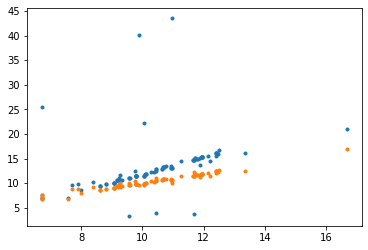

In [101]:
plt.plot(rtz,  rtv, '.')
plt.plot(rtz,  rtvg, '.')

(-2.0, 2.0)

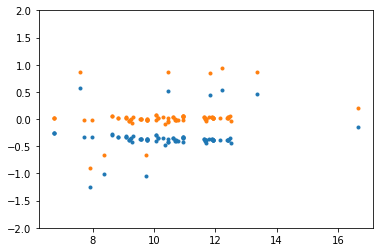

In [104]:
plt.plot(rt, np.subtract(rt, rtm), '.')
plt.plot(rt, np.subtract(rt, rtmg), '.')
plt.ylim(-2,2)

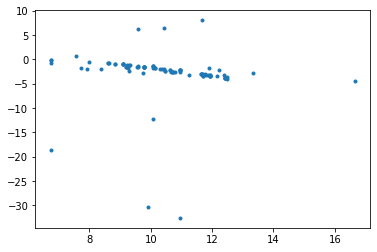

In [76]:
plt.plot(zikrt, np.subtract(zikrt, vlrt), '.')


In [67]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [54]:
with_mod.to_csv(osp+'positive_mode/limma_independent_toptable_features_individual_logfc_annotated_corrected.csv')

In [55]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(with_mod)

     row m/z  row retention time  adj-p  t-val  logFC  custom_id     vl  \
0     148.07               11.92   0.00  -7.29 -11.18        633 -21.41   
1     147.08               11.91   0.00  -7.13  -2.63        613  -5.02   
2     905.59                3.00   0.00  -7.09 -10.21       3109 -19.51   
3     837.62                3.15   0.00  -6.98 -12.54       3028 -21.45   
4     810.60                3.17   0.00  -6.92  -1.78       2989  -3.29   
5     782.57                3.20   0.00  -6.85  -1.79       2936  -3.36   
6     126.02               12.21   0.00  -6.82  -1.05        324  -1.67   
7     784.58                3.20   0.00  -6.68  -1.45       2938  -2.64   
8     133.06               10.33   0.00   6.64   1.75        425   3.28   
9     812.61                3.17   0.00  -6.61  -1.65       2992  -3.03   
10    785.59                3.20   0.00  -6.59  -1.51       2939  -2.75   
11    169.06               11.90   0.00  -6.55  -2.20        926  -4.23   
12    171.08             

In [84]:
with_mod.to_csv(osp+'positive_mode/limma_independent_toptable_features_individual_logfc_annotated_corrected.csv')

In [86]:
def compute_adducts(mz, positive = True):

        PROTON = 1.00727646677
        if positive:
            addList = [(mz - PROTON, 'M+H[1+]', ''),
                 ((mz - PROTON)*2, 'M+2H[2+]', ''),
                 ((mz - PROTON)*3, 'M+3H[3+]', ''),
                 (mz - 1.0034 - PROTON, 'M(C13)+H[1+]', 'C'),
                 ((mz - 0.5017 - PROTON)*2, 'M(C13)+2H[2+]', 'C'),
                 ((mz - 0.3344 - PROTON)*3, 'M(C13)+3H[3+]', 'C'),
                 (mz -1.9958 - PROTON, 'M(S34)+H[1+]', 'S'),
                 (mz -1.9972 - PROTON, 'M(Cl37)+H[1+]', 'Cl'),
                 (mz - 21.9820 - PROTON, 'M+Na[1+]', ''),
                 ((mz - 10.991 - PROTON)*2, 'M+H+Na[2+]', ''),
                 (mz - 37.9555 - PROTON, 'M+K[1+]', ''),
                 (mz - 18.0106 - PROTON, 'M+H2O+H[1+]', ''),
                 (mz + 18.0106 - PROTON, 'M-H2O+H[1+]', 'H2O'),
                 (mz + 36.0212 - PROTON, 'M-H4O2+H[1+]', 'H4O2'),
                 (mz + 17.0265 - PROTON, 'M-NH3+H[1+]', 'NH3'),
                 (mz + 27.9950 - PROTON, 'M-CO+H[1+]', 'CO'),
                 (mz + 43.9898 - PROTON, 'M-CO2+H[1+]', 'CO2'),
                 (mz + 46.0054 - PROTON, 'M-HCOOH+H[1+]', 'H2CO2'),
                 (mz - 67.9874 - PROTON, 'M+HCOONa[1+]', ''),
                 (mz + 67.9874 - PROTON, 'M-HCOONa+H[1+]', 'HCO2Na'),
                 (mz - 57.9586 - PROTON, 'M+NaCl[1+]', ''),
                 (mz + 72.0211 - PROTON, 'M-C3H4O2+H[1+]', 'C3H4O2'),
                 (mz - 83.9613 - PROTON, 'M+HCOOK[1+]', ''),
                 (mz + 83.9613 - PROTON, 'M-HCOOK+H[1+]', 'HCO2K'),
                 ]

        return addList

In [6]:
with_mod = pd.read_csv(osp+'positive_mode/limma_independent_toptable_features_individual_logfc.csv')

In [103]:
ind = pd.read_csv(osp+'/negative_mode/samples/individual_logfc.csv', index_col=0)

In [104]:
ind

,mal_logFC,vl_logFC,zik_logFC
10,-0.089090,0.872203,-0.201817
18,3.173904,-1.042365,-1.969181
36,0.298561,23.921933,2.510075
41,-0.167381,-21.467091,0.376985
52,-0.134543,-0.536124,-0.118773
...,...,...,...
3130,-3.041554,-0.361098,-9.146552
3154,-1.653397,4.739212,2.540878
3904,-3.349854,-4.405461,7.602475
4644,3.662188,3.890283,2.722449


In [105]:
with_mod['common'] = None
for index,row in with_mod.iterrows():
    mal = row['mal']
    
    vl = row['vl']
    zik = row['zik']
    
    if mal == None or vl == None or zik == None:
        with_mod.at[index, 'common'] = 'None'
    else:
        if mal <= 0 and vl <= 0 and zik <= 0:
            with_mod.at[index, 'common'] = 'down'
        elif mal > 0 and vl > 0 and zik > 0:
            with_mod.at[index, 'common'] = 'up'
        else:
            if (mal > 0 and vl <= 0 and zik <= 0) or (mal <= 0 and vl > 0 and zik > 0):
                with_mod.at[index, 'common'] = 'mal'
            elif (vl > 0 and mal <= 0 and zik <= 0) or (vl <= 0 and mal > 0 and zik > 0):
                with_mod.at[index, 'common'] = 'vl'
            elif (zik > 0 and mal <= 0 and vl <= 0) or (zik <= 0 and mal > 0 and vl > 0):
                with_mod.at[index, 'common'] = 'zik'

In [107]:
ind.to_csv(osp+'negative_mode/samples/individual_logfc.csv')

In [98]:
with_mod.to_csv(osp+'positive_mode/individual_logfc2.csv')

In [96]:
print("Number of peaks going up: {}".format(len(with_mod[with_mod['common'] == 'up'])))
print("Number of peaks going down: {}".format(len(with_mod[with_mod['common'] == 'down'])))
print("Number of peaks going up/down only in Malaria: {}".format(len(with_mod[with_mod['common'] == 'mal'])))
print("Number of peaks going up/down only in VL: {}".format(len(with_mod[with_mod['common'] == 'vl'])))
print("Number of peaks going up/down only in Zika: {}".format(len(with_mod[with_mod['common'] == 'zik'])))


Number of peaks going up: 35
Number of peaks going down: 147
Number of peaks going up/down only in Malaria: 151
Number of peaks going up/down only in VL: 147
Number of peaks going up/down only in Zika: 140


In [94]:
print("Number of peaks going up: {}".format(len(ind[ind['common'] == 'up'])))
print("Number of peaks going down: {}".format(len(ind[ind['common'] == 'down'])))
print("Number of peaks going up/down only in Malaria: {}".format(len(ind[ind['common'] == 'mal'])))
print("Number of peaks going up/down only in VL: {}".format(len(ind[ind['common'] == 'vl'])))
print("Number of peaks going up/down only in Zika: {}".format(len(ind[ind['common'] == 'zik'])))


Number of peaks going up: 30
Number of peaks going down: 150
Number of peaks going up/down only in Malaria: 149
Number of peaks going up/down only in VL: 151
Number of peaks going up/down only in Zika: 145


In [82]:
print("Number of peaks going up: {}".format(len(with_mod[with_mod['common'] == 'up'])))
print("Number of peaks going down: {}".format(len(with_mod[with_mod['common'] == 'down'])))
print("Number of peaks going up/down only in Malaria: {}".format(len(with_mod[with_mod['common'] == 'mal'])))
print("Number of peaks going up/down only in VL: {}".format(len(with_mod[with_mod['common'] == 'vl'])))
print("Number of peaks going up/down only in Zika: {}".format(len(with_mod[with_mod['common'] == 'zik'])))

Number of peaks going up: 38
Number of peaks going down: 158
Number of peaks going up/down only in Malaria: 155
Number of peaks going up/down only in VL: 138
Number of peaks going up/down only in Zika: 134


In [51]:
sys.path.append('..')
import peakinfo
import pickle
with open(osp+'positive_mode/peakinfolist.dict', 'rb') as file:
    peakinfolist_positive = pickle.load(file)

    

In [52]:
with_mod['std_annot'] = None
with_mod['mm_annot'] = None
with_mod['hmdb_ms2_annot'] = None

for index,row in with_mod.iterrows():
    cid = row['custom_id']
    for peak in peakinfolist_positive:
        if int(cid) == int(peak.cid.split('p')[1].split('.')[0]):
            with_mod.at[index, 'std_annot'] = peak.std_annotation
            with_mod.at[index, 'mm_annot'] = peak.mm_annotation
            with_mod.at[index, 'hmdb_ms2_annot'] = peak.ms2_annotation

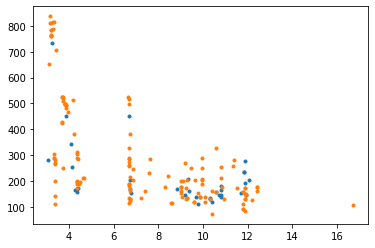

In [26]:
plt.plot(with_mod[with_mod['common'] == 'up']['row retention time'],with_mod[with_mod['common'] == 'up']['row m/z'],'.')
plt.plot(with_mod[with_mod['common'] == 'down']['row retention time'],with_mod[with_mod['common'] == 'down']['row m/z'],'.')

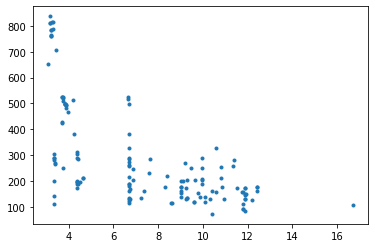

In [25]:
plt.plot(with_mod[with_mod['common'] == 'down']['row retention time'],with_mod[with_mod['common'] == 'down']['row m/z'],'.')

In [63]:
with_mod.to_csv(osp+'positive_mode/limma_independent_toptable_features_individual_logfc_3ppm.csv')

In [132]:
cids = []
for _,rows in with_mod.iterrows():
    vl = rows['vl']
    mal = rows['mal']
    zik = rows['zik']
    pval = rows['adj-p']
    cid = rows['custom_id']
    
    if pval <= 0.05:

            if vl > 0.05 and mal > 0.05 and zik > 0.05:
                cids.append(cid)
            
        

In [133]:
len(cids)

64

In [137]:
import pickle
with open(output_dir + 'metabolites_insig_individ.txt', 'wb') as handle:
    pickle.dump(cids, handle)

In [58]:
cids.to_csv(output_dir+'list_of_ids_insignificant', header=True, index=None, sep=',', mode='w')

AttributeError: 'list' object has no attribute 'to_csv'

In [163]:
MNET_PATH = '/Users/anamaria/git/molnet/code/'
sys.path.append(MNET_PATH)
with open(os.path.join(osp,'pymz/mzmine/HMDBannodat.csv'), 'rb') as file:
    ann = pickle.load(file)

In [166]:
with_mod.loc[324]

row m/z              236.07
row retention time     4.67
adj-p                  0.31
t-val                 -1.40
custom_id              1798
vl                     0.03
mal                    0.76
zik                    0.60
Name: 324, dtype: object

In [164]:
ann

,row m/z,row retention time,adj p-val,t-score,custom_id,compound_names,compound_id,pathway,standards_match,spectra,adducts,hmdbacc,hmdbname,matchesHMDB,HMDBspecAnno
1401,203.05,12.05,0.00,7.89,1401,"['D-Tagatose; lyxo-Hexulose$1,7-Dimethylxanthi...",['E351'],"['Tryptophan metabolism', 'Caffeine metabolism...",NaN,{'frag_pos_mal': Spectrum from scan 2262 in /V...,"[(202.04510588796632, M+H[1+], ), (404.0902117...","[HMDB0062551, HMDB0000295, HMDB0014988, HMDB00...","[4-ethylphenylsulfate, Uridine 5'-diphosphate,...","[(HMDB0014988, 0.10091398134601763, Spectrum f...",[]
2664,468.31,3.97,0.00,-7.69,2664,['Timnodonyl carnitine'],['E385'],['Carnitine shuttle'],NaN,{'frag_pos_mal': Spectrum from scan 3642 in /V...,"[(467.30115930988427, M+H[1+], ), (934.6023186...","[HMDB0000998, HMDB0076294, HMDB0076299, HMDB00...","[dCTP, CL(a-13:0/i-19:0/18:2(9Z,11Z)/18:2(9Z,1...","[(HMDB0015325, 0.04792514380900029, Spectrum f...",[]
613,147.08,11.91,0.00,-7.21,613,"['5,6-Dihydrothymine; Dihydrothymine; 5,6-Dihy...","['E171', 'E237']","['Pyrimidine metabolism', 'Nitrogen metabolism...",NaN,{'frag_pos_mal': Spectrum from scan 1206 in /V...,"[(146.06913101597954, M+H[1+], ), (292.1382620...","[HMDB0000182, HMDB0000208, HMDB0000422, HMDB00...","[L-Lysine, Oxoglutaric acid, 2-Methylglutaric ...","[(HMDB0000641, 0.47978524104955117, Spectrum f...","[((146.1445, C5H10N2O3, L-Glutamine), 0.479785..."
324,126.02,12.21,0.00,-7.01,324,['Taurine; 2-Aminoethanesulfonic acid; Aminoet...,['E288'],"['Methionine and cysteine metabolism', 'Bile a...",NaN,{'frag_pos_mal': Spectrum from scan 699 in /Vo...,"[(125.0147042204216, M+H[1+], ), (250.02940844...","[HMDB0000251, HMDB0000898, HMDB0001861, HMDB00...","[Taurine, 1-Methylhistamine, 3-Methylhistamine...","[(HMDB0000479, 0.015941508107824173, Spectrum ...",[]
3108,904.59,3.00,0.00,-6.96,3108,NaN,row19,NaN,NaN,{'gnps2': Spectrum from scan 2029 in /Volumes/...,"[(903.5830648524384, M+H[1+], ), (1807.1661297...","[HMDB0005385, HMDB0005426, HMDB0005461, HMDB00...","[TG(16:0/18:1(9Z)/20:4(5Z,8Z,11Z,14Z)), TG(16:...","[(0, 0, 0)]",[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,158.12,8.66,0.92,0.12,777,NaN,row589,NaN,NaN,{'frag_pos_vl': Spectrum from scan 2096 in /Vo...,"[(157.11036220787932, M+H[1+], ), (314.2207244...","[HMDB0000459, HMDB0014447, HMDB0014755, HMDB00...","[3-Methylcrotonylglycine, Tranexamic Acid, Par...","[(HMDB0000517, 0.25613996616596296, Spectrum f...",[]
1822,239.14,4.38,0.94,-0.10,1822,NaN,row594,NaN,NaN,{'frag_pos_mal': Spectrum from scan 2794 in /V...,"[(238.13169486196526, M+H[1+], ), (476.2633897...","[HMDB0014562, HMDB0014836, HMDB0015084, HMDB00...","[Secobarbital, Nitrofurantoin, Felbamate, Biop...","[(HMDB0001964, 0.1534860731591503, Spectrum fr...",[]
636,148.10,6.83,0.96,-0.07,636,['Pantothenate; Pantothenic acid; (R)-Pantothe...,"['E23', 'E165']",['Vitamin B5 - CoA biosynthesis from pantothen...,NaN,{'frag_pos_mal': Spectrum from scan 1249 in /V...,"[(147.0895086919544, M+H[1+], ), (294.17901738...","[HMDB0000148, HMDB0003011, HMDB0003339, HMDB00...","[L-Glutamic acid, O-Acetylserine, D-Glutamic a...","[(HMDB0000017, 0.2308221620676222, Spectrum fr...",[]
805,159.11,10.41,0.98,-0.04,805,NaN,row599,NaN,NaN,{'frag_pos_vl': Spectrum from scan 2164 in /Vo...,"[(158.10559349863266, M+H[1+], ), (316.2111869...","[HMDB0000462, HMDB0000635, HMDB0000847, HMDB00...","[Allantoin, Succinylacetone, Pelargonic acid, ...","[(HMDB0000197, 0.17020043888508127, Spectrum f...",[]


In [165]:
for i in range(len(cids)):
    if cids[i] in ann.index:
        print(i,cids[i],ann.loc[cids[i]]['standards_match'])
        
        print(ann.loc[cids[i]]['matchesHMDB'])
        print(ann.loc[cids[i]]['HMDBspecAnno'])
        print(ann.loc[cids[i]]['compound_names'])
        
        print('==============================================================================')

0 1993 sn-glycero-3-Phosphocholine
[('HMDB0015576', 0.1310692376203601, <mnet.Spectrum object at 0x124a1e790>), ('HMDB0014695', 0.14199269357379657, <mnet.Spectrum object at 0x124a1e7c0>)]
[]
nan
1 952 nan
[('HMDB0000670', 0.31654856105313567, <mnet.Spectrum object at 0x124a1eaf0>)]
[]
nan
2 366 5-Oxoproline
[('HMDB0000897', 0.08628637561716006, <mnet.Spectrum object at 0x124a1ec40>), ('HMDB0000070', 0.36276145491431677, <mnet.Spectrum object at 0x124a1ec70>)]
[(('129.157', 'C6H11NO2', 'Pipecolic acid'), 0.36276145491431677)]
['1-Pyrroline-4-hydroxy-2-carboxylate$5-Oxo-L-proline$L-1-Pyrroline-3-hydroxy-5-carboxylate; 3-Hydroxy-L-1-pyrroline-5-carboxylate; (3R,5S)-1-Pyrroline-3-hydroxy-5-carboxylate$5-Oxoproline; Pyroglutamic acid; 5-Pyrrolidone-2-carboxylic acid; Pyroglutamate; 5-Oxo-L-proline; L-Pyroglutamic acid; L-5-Pyrrolidone-2-carboxylic acid', 'L-4-Hydroxyglutamate semialdehyde$D-Glutamate; D-Glutamic acid; D-Glutaminic acid; D-2-Aminoglutaric acid$L-Glutamate; L-Glutamic acid; 

In [125]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(with_mod)

          logFC        t  P.Value  adj.P.Val   row m/z   row rt     mal      vl     zik
3022  -11.33130 -8.69038  0.00000    0.00000 833.58745  3.13144    None    None 0.98242
1517  -10.24873 -8.57249  0.00000    0.00000 213.09409 11.95398 0.96493 0.00000 0.61075
2947   -2.08999 -8.22249  0.00000    0.00000 788.61208  3.18832 0.76168 0.00001 0.35794
1401    2.54919  7.88909  0.00000    0.00000 203.05263 13.54806    None 0.14643 0.82484
101    -2.08820 -7.76761  0.00000    0.00000 101.07178 12.98222    None    None    None
2664   -1.90723 -7.68673  0.00000    0.00000 469.31196  3.97423 0.13870 0.01179 0.80425
2987   -1.86304 -7.61452  0.00000    0.00000 810.60001  3.17127 0.90425 0.00000 0.94713
2175    1.87656  7.58335  0.00000    0.00000 280.26343 22.69388    None    None 0.97127
2985   -2.02375 -7.30058  0.00000    0.00000 809.58754  3.18517 0.95649 0.00000 0.85724
2912   -1.59756 -7.22493  0.00000    0.00000 768.55257  3.12411 0.98420 0.00000 0.55699
2549   -0.94566 -7.22200  0.0000

In [89]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(with_mod)

           logFC         t       P.Value     adj.P.Val     row m/z     row rt   mal           vl
3022  -11.331295 -8.690375  5.255238e-13  2.670170e-10  833.587449   3.131435  None         None
1517  -10.248729 -8.572486  8.841622e-13  2.670170e-10  213.094092  11.953978  None         None
2947   -2.089988 -8.222488  4.142949e-12  8.341137e-10  788.612085   3.188320  None  5.18657e-06
1401    2.549193  7.889092  1.800742e-11  2.719120e-09  203.052629  13.548055  None         None
101    -2.088202 -7.767609  3.073015e-11  3.712202e-09  101.071779  12.982221  None         None
...          ...       ...           ...           ...         ...        ...   ...          ...
10779  -0.006983 -0.032195  9.744013e-01  9.808212e-01  170.153955   9.201242  None         None
2057    0.007572  0.030247  9.759495e-01  9.808212e-01  268.176428   9.853239  None         None
2476    0.004093  0.015505  9.876699e-01  9.909512e-01  344.227831   4.196603  None         None
1393   -0.001946 -0.012650  9.

In [81]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [28]:
nomod = {}
mod = {}
for _,row in without_mod.iterrows():
    mz = row["row m/z"]
    rt = row["row retention time"]
    idc = np.int(row["custom_id"])
    nomod[round(mz,2)] = idc
for _,row in with_mod.iterrows():
    mz = row["row m/z"]
    rt = row["row retention time"]
    idc = np.int(row["custom_id"])
    mod[round(mz,2)] = idc

In [37]:
def intersection(lst1, lst2): 
    return set(lst1).intersection(lst2) 
      
inters  = intersection(mod.keys(),  nomod.keys())

In [55]:
found = []
notfound = []
for i in mod:
    if i in list(inters):
        found = mod[i]
    else:
        notfound = mod[i]


In [25]:
with_mod

,row m/z,row retention time,adj-p,t-val,custom_id
0,148.073458,11.915377,1.707271e-07,-7.230248,633
1,147.076407,11.905214,1.707271e-07,-7.050995,613
2,905.593771,2.998939,1.707271e-07,-7.048608,3109
3,810.600011,3.171275,3.354703e-07,-6.773560,2989
4,126.021981,12.209536,3.354703e-07,-6.770043,324
...,...,...,...,...,...
599,257.113047,8.046586,9.784447e-01,-0.035265,1982
600,118.086244,9.607425,9.792079e-01,-0.032271,240
601,264.180478,3.470832,9.818751e-01,0.026886,2037
602,186.112544,9.397406,9.974883e-01,-0.005236,1154


In [7]:
mod_sig = with_mod[with_mod['adj-p'] < 0.05]
nomod_sig = without_mod[without_mod['adj p-val'] < 0.05]




nomod = {}
mod = {}

mod_rt = []
nomod_rt = []

mod_mz = []
nomod_mz = []

for _,row in nomod_sig.iterrows():
    mz = row["row m/z"]
    rt = row["row retention time"]
    idc = np.int(row["custom_id"])
    nomod[round(mz,2)] = idc
    nomod_rt.append(rt)
    nomod_mz.append(mz)
    
for _,row in mod_sig.iterrows():
    mz = row["row m/z"]
    rt = row["row retention time"]
    idc = np.int(row["custom_id"])
    mod[round(mz,2)] = idc
    mod_rt.append(rt)
    mod_mz.append(mz)

def intersection(lst1, lst2): 
    return set(lst1).intersection(lst2) 
      
inters  = intersection(mod.keys(),  nomod.keys())


found = []
notfound = []
for i in mod:
    if i in list(inters):
        found.append(mod[i])
    else:
        notfound.append(mod[i])

        

for i in (list(intersection(names_notfound, names_found))):
    print("=============")
    print(i)
    
for i in names_notfound:
    if i not in (list(intersection(names_notfound, names_found))):
        print("=============")
        print(i)

NameError: name 'names_notfound' is not defined

### Check intersection metabolites by m/z

In [16]:
inters = 0
for _,row in zik.iterrows():
    mz = row['row m/z']
    rt = row['row retention time']
    for _,rowc in mal_no.iterrows():
        mzc = rowc['row m/z']
        rtc = rowc['row retention time']
        if (mz < (mzc+0.001)  or  mz > (mzc-0.001)):
            inters+=1
            break
            #print(row)

In [17]:
inters


12393

In [30]:
print("Mal sig: {}, VL sig: {}, Zik sig: {}".format(len(mal_sig), len(vl_sig), len(zik_sig)))

NameError: name 'mal_sig' is not defined

In [31]:
c=0
z=0
for _,row in nomod_sig.iterrows():
    mz = row['row m/z']
    rt = row['row retention time']
    for _,row in vl_sig.iterrows():
        mz_vl = row['row m/z']
        rt_vl = row['row retention time']
        if mz_vl > (mz - 0.01) and mz_vl < (mz + 0.01):
            c+=1
            if rt_vl > (rt - 300) and rt_vl < (rt +300):
                z+=1
print(c,z)

NameError: name 'vl_sig' is not defined

### Check retention times

In [9]:
nice_fonts = {"text.usetex": True,
            "font.family": "serif",
            "font.serif" : "Times New Roman"}
plt.rcParams.update(nice_fonts)

plt.rc('font', family='serif', size=19)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)


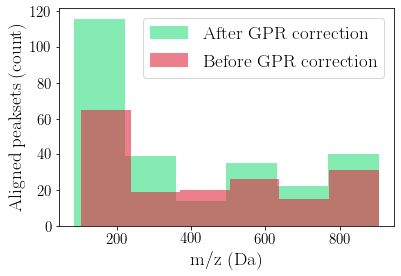

In [23]:
fig, ax = plt.subplots()
plt.hist(mod_mz, bins = 6,alpha = 0.6, label = 'After GPR correction', color = '#32E081')
plt.hist(nomod_mz,bins=6, alpha = 0.6, label = 'Before GPR correction', color = '#E02A3F')
plt.legend()
plt.xlabel('m/z (Da)')
plt.ylabel('Aligned peaksets (count)')
fig.savefig('/Users/anamaria/Desktop/thesis_pictures/gpr/peaksets_mz_eval.png', format = 'png', dpi =400, bbox_inches='tight')

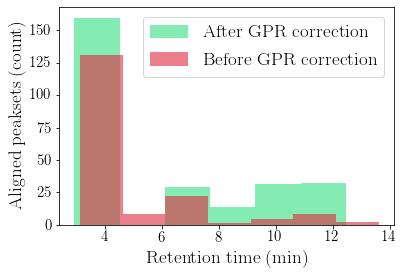

In [24]:
fig, ax = plt.subplots()
plt.hist(mod_rt, bins = 6,alpha = 0.6, label = 'After GPR correction', color = '#32E081')
plt.hist(nomod_rt,bins=7, alpha = 0.6, label = 'Before GPR correction', color = '#E02A3F')
plt.legend()
plt.xlabel('Retention time (min)')
plt.ylabel('Aligned peaksets (count)')
fig.savefig('/Users/anamaria/Desktop/thesis_pictures/gpr/peaksets_rt_eval.png', format = 'png', dpi =400, bbox_inches='tight')

unpreprocessed data: Most of the peaks which align are found in the interval [3,7] and very few in [8,14]



preprocessed data: More peaks align in the interval [8,14]

So the modelling mainly influences the metabolites eluted after 8 min.

In [ ]:
c=0
z=0
for _,row in vl_sig_new.iterrows():
    mz = row['row m/z']
    mz = np.round(mz,3)
    rt = row['row retention time']
    for _,rowl in zik_sig.iterrows():
        mz_vl = rowl['row m/z']
        
        rt_vl = rowl['row retention time']
        if mz_vl > (mz - 0.01) and mz_vl < (mz + 0.01):
            c+=1
            if rt_vl > (rt - 30/60) and rt_vl < (rt +30/60):
                z+=1
                
print(c,z)


c=0
z=0
for _,row in mal_sig.iterrows():
    mz = row['row m/z']
    rt = row['row retention time']
    for _,row in zik_sig.iterrows():
        mz_vl = row['row m/z']
        rt_vl = row['row retention time']
        if mz_vl > (mz - 0.01) and mz_vl < (mz + 0.01):
            c+=1
            if rt_vl > (rt - 300) and rt_vl < (rt +300):
                z+=1
print(c,z)

cv=0
zv=0
for _,row in mod_sig.iterrows():
    mz = row['row m/z']
    rt = row['row retention time']
    for _,rowl in nomod_sig.iterrows():
        mz_vl = rowl['row m/z']
        rt_vl = rowl['row retention time']
        if mz_vl > (mz - 0.01) and mz_vl < (mz + 0.01):
            cv+=1
            if rt_vl > (rt - 300/60) and rt_vl < (rt +300/60):
                zv+=1
                print(mz, rt)
                print(mz_vl, rt_vl)
            print('-------')
print(cv,zv)

plt.hist(mod_mz,)
plt.hist(nomod_mz, alpha = 0.5)

plt.xlabel('m/z')
plt.ylabel('Peaks (#)')

plt.hist(mod_mz, color = 'pink')
plt.hist(nomod_mz, alpha = 0.5)
plt.hist(mod_sig['row m/z'], alpha = 0.4)
plt.hist(nomod_sig['row m/z'], alpha = 0.3)


plt.xlabel('m/z')
plt.ylabel('Peaks (#)')

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(mod_sig['row m/z'], bins=100)
plt.hist(nomod_sig['row m/z'], alpha = 0.5, bins=100)

plt.xlabel('m/z')
plt.ylabel('Peaks (#)')

sns.distplot(mod_sig['row m/z'])
sns.distplot(nomod_sig['row m/z'])

sns.distplot(mod_sig['row retention time'])
sns.distplot(nomod_sig['row retention time'])

plt.figure(figsize=(15,5))
plt.hist(mod_sig['row retention time'], bins=100)
plt.hist(nomod_sig['row retention time'], alpha = 0.5, bins=100)

plt.xlabel('RT')
plt.ylabel('Peaks (#)')


plt.figure(figsize=(15,5))
plt.hist(mod_sig['row m/z'], bins=50)
plt.hist(nomod_sig['row m/z'], alpha = 0.5, bins=50)
plt.hist(vl_sig['row m/z'], alpha = 0.5, bins=50)
plt.xlabel('m/z')
plt.ylabel('Peaks (#)')

plt.figure(figsize=(15,5))
plt.hist(mod_sig['row m/z'], bins=50)
plt.hist(nomod_sig['row m/z'], alpha = 0.5, bins=50)
plt.hist(zik_sig['row m/z'], alpha = 0.8, bins=50)
plt.xlabel('m/z')
plt.ylabel('Peaks (#)')

plt.figure(figsize=(15,5))
plt.hist(mod_sig['row m/z'], bins=50)
plt.hist(nomod_sig['row m/z'], alpha = 0.5, bins=50)
plt.hist(mal_sig['row m/z'], alpha = 0.8, bins=50)
plt.xlabel('m/z')
plt.ylabel('Peaks (#)')


plt.hist(mod_rt)
plt.hist(nomod_rt, alpha = 0.5)
plt.hist(zik['row retention time'], alpha = 0.5)

plt.xlabel('RT')
plt.ylabel('Peaks (#)')

plt.hist(mod_rt)
plt.hist(nomod_rt, alpha = 0.5)
plt.hist(mal['row retention time'], alpha = 0.5)
plt.xlabel('RT')
plt.ylabel('Peaks (#)')